# Reconocimiento de comandos de voz

In [ ]:
try:
    import torchinfo
except:
    ! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

In [ ]:
import random
from itertools import islice as take
import librosa
import librosa.display
import IPython as ip
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import torchvision.models as tvm
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from torchinfo import summary
from tqdm.auto import trange
import collections
from os.path import join
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

Otras importaciones

In [ ]:
from torch.optim import Adam

In [ ]:
#Creamos carpeta en colab para los datos (no ejecutar si ya existe la carpeta):
! mkdir datos

In [ ]:
# directorio de datos
DATA_DIR = 'datos'
ds = SPEECHCOMMANDS(DATA_DIR, download=True)

100%|██████████| 2.26G/2.26G [04:43<00:00, 8.55MB/s]


## El conjunto de datos

In [ ]:
# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# parámetros FFT
N_FFT = 400
HOP_LENGTH = N_FFT // 2

# SpeechCommands classes
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn',
    'left', 'marvin', 'nine', 'no', 'off',
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)

NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}
print(CLASS_IDX)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed(150)

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


Se define la función para transformación a espectrograma Mel.

In [ ]:
melspect = T.MelSpectrogram(n_fft=N_FFT, hop_length=HOP_LENGTH)

C:\Users\duffl\anaconda3\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
def identity(x):
    return x


def label2index(label):
    return CLASS_IDX[label]


class SPEECHCOMMANDS2(SPEECHCOMMANDS):

    def __init__(self, root, download=False, subset=None,
                 waveform_tsfm=identity, label_tsfm=identity):
        super().__init__(root=root, download=download, subset=subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm

    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
        x = melspect(self.waveform_tsfm(waveform)) # se aplica la transformación a espectrograma Mel
        y = self.label_tsfm(label)
        return x, y, label, sample_rate

In [ ]:
class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=SECS, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate

    def forward(self, waveform):
        samples = waveform.shape[1]

        if samples < self.samples:
            difference = self.samples - samples
            padding = torch.zeros(1, difference)
            waveform = torch.cat([waveform, padding], 1)

        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)

        return waveform

## Dataset y Dataloader

In [ ]:
# creamos un Dataset
ds_ent = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm = WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
    subset = "training"
)

ds_val = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm = WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
    subset = "validation"
)

ds_pru = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm = WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
    subset = "testing"
)

print("Tamaño entrenamiento:",len(ds_ent))
print("Tamaño validación:", len(ds_val))
print("Tamaño prueba:", len(ds_pru))

Tamaño entrenamiento: 84843
Tamaño validación: 9981
Tamaño prueba: 11005


Se crean los cargadores de datos.

In [ ]:
# creamos los DataLoader
dl_ent = DataLoader(ds_ent, batch_size=BATCH_SIZE, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True)
dl_pru = DataLoader(ds_pru, batch_size=1, shuffle=True)

Se observa la forma de un lote (de 32).

In [ ]:
x_sample, y_sample, labels_sample, sr_sample = next(iter(dl_ent))
print(f'x shape={x_sample.shape} dtype={x_sample.dtype}')
print(f'y shape={y_sample.shape} dtype={y_sample.dtype}')

x shape=torch.Size([32, 1, 128, 81]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


Ahora se observa el aplanamiento de un lote de X.

In [ ]:
x_sample_plano = torch.flatten(x_sample, start_dim = 2)
print(f'x shape={x_sample_plano.shape}')

x shape=torch.Size([32, 1, 10368])


## Entrenamiento y redes

In [ ]:
# Constantes para el entrenamiento
N_EPOCAS = 20
LOGDIR = './logs/'
DC = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
    estado_modelo = {'epoch': epoca,
                     'model_state_dict': modelo.state_dict(),
                     'optimizer_state_dict': opt.state_dict()}
    torch.save(estado_modelo, ckptpath)

In [ ]:
def registra_info_tboard(writer, epoca, hist):
    for (m,v) in hist.items():
        writer.add_scalar(m, v[epoca], epoca)

In [ ]:
def exactitud(y_hat, y):
    cmp = y_hat.argmax(dim=-1) == y
    aciertos = torch.count_nonzero(cmp)
    return aciertos / cmp.shape[0]

In [ ]:
def paso_ent(modelo, fp, metrica, opt, X, y):
    opt.zero_grad() # se ponen los gradientes asociados a los parámetros a actualizar en cero
    y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
    perdida = fp(y_hat, y) # se calcula la pérdida
    perdida.backward() # se obtienen los gradientes
    opt.step() # se actualizan todos los parámetros del modelo

    with torch.no_grad():
        perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
        metricas_paso = metrica(y_hat, y)

    return perdida_paso, metricas_paso

In [ ]:
import copy

def entrena(modelo, fp, metrica, opt, entdl, valdl, disp, ckptpath, n_epocas = 10, tbdir = 'runs/', aplanar=False):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {'perdida_ent':np.zeros(n_epocas),
            'perdida_val': np.zeros(n_epocas),
            metrica.__name__ + '_ent': np.zeros(n_epocas),
            metrica.__name__ + '_val': np.zeros(n_epocas)}

    tbwriter = SummaryWriter(tbdir)
    perdida_min = torch.inf
    mejor_modelo = copy.deepcopy(modelo)
    for e in range(n_epocas):
        # bucle de entrenamiento
        modelo.train()
        for p, (Xlote,ylote,_,_) in enumerate(entdl):
            if(aplanar):
                Xlote = torch.flatten(Xlote, start_dim = 2)
            Xlote = Xlote.to(disp)
            ylote = ylote.type(torch.LongTensor) # agregada
            ylote = ylote.to(disp)
            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)
            hist['perdida_ent'][e] += perdida_paso
            hist[metrica.__name__ + '_ent'][e] += metrica_paso

        # bucle de validación
        modelo.eval()
        with torch.no_grad():
            for Xlote,ylote,_,_ in valdl:
                if(aplanar):
                    Xlote = torch.flatten(Xlote, start_dim = 2)
                Xlote = Xlote.to(disp)
                ylote = ylote.type(torch.LongTensor) # agregada
                ylote = ylote.to(disp)
                y_hat = modelo(Xlote)
                hist['perdida_val'][e] += fp(y_hat, ylote)
                hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

        hist['perdida_ent'][e] /=  n_lotes_ent
        hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
        hist['perdida_val'][e] /=  n_lotes_val
        hist[metrica.__name__ + '_val'][e] /= n_lotes_val
        # guardamos checkpoint y copiamos pesos y sesgos del modelo actual si disminuye la metrica a monitorear
        if hist['perdida_val'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)

        registra_info_tboard(tbwriter, e, hist)
        print(f'\nÉpoca {e}: Perdida(E) = {hist["perdida_ent"][e]:.3f}, {metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, Perdida(V) = {hist["perdida_val"][e]:.3f}, {metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')
    return modelo, mejor_modelo, hist

## Modelo de convolución 1d

Se creará una red neuronal con una capa convolucional 1d. La red toma un ejemplar aplanado del audio.

In [ ]:
red1 = nn.Sequential(nn.Conv1d(x_sample_plano.shape[1], 15, kernel_size=3, padding=1),
                     nn.ReLU(),
                     nn.Linear(x_sample_plano.shape[-1],20),
                     nn.Sigmoid(),
                     nn.BatchNorm1d(15),
                     nn.Flatten(),
                     nn.Dropout(p=0.25),
                     nn.Linear(300, NUM_CLASSES))

Se prueba con un batch de ejemplo.

In [ ]:
yhat_flat = red1.forward(x_sample_plano)
print(yhat_flat.shape)

torch.Size([32, 35])


Se entrena esta red neuronal y se grafica la pérdida y la exactitud.

In [ ]:
red1.to(DC)

perdida = nn.CrossEntropyLoss(weight=None, reduction='mean', label_smoothing=0.1)
opt = Adam(red1.parameters(), lr=1e-4)

red1, mejor_red1, hist = entrena(red1, perdida, exactitud, opt, dl_ent, dl_val, DC, LOGDIR + 'red1.pt', n_epocas=N_EPOCAS, tbdir = LOGDIR, aplanar=True)


Época 0: Perdida(E) = 2.341, exactitud(E) = 0.436, Perdida(V) = 2.287, exactitud(V) = 0.466

Época 1: Perdida(E) = 2.245, exactitud(E) = 0.472, Perdida(V) = 2.218, exactitud(V) = 0.488

Época 2: Perdida(E) = 2.176, exactitud(E) = 0.497, Perdida(V) = 2.170, exactitud(V) = 0.513

Época 3: Perdida(E) = 2.122, exactitud(E) = 0.520, Perdida(V) = 2.150, exactitud(V) = 0.514

Época 4: Perdida(E) = 2.079, exactitud(E) = 0.535, Perdida(V) = 2.121, exactitud(V) = 0.532

Época 5: Perdida(E) = 2.044, exactitud(E) = 0.547, Perdida(V) = 2.105, exactitud(V) = 0.536

Época 6: Perdida(E) = 2.012, exactitud(E) = 0.560, Perdida(V) = 2.113, exactitud(V) = 0.529

Época 7: Perdida(E) = 1.986, exactitud(E) = 0.568, Perdida(V) = 2.106, exactitud(V) = 0.531

Época 8: Perdida(E) = 1.960, exactitud(E) = 0.578, Perdida(V) = 2.085, exactitud(V) = 0.541

Época 9: Perdida(E) = 1.942, exactitud(E) = 0.585, Perdida(V) = 2.093, exactitud(V) = 0.538

Época 10: Perdida(E) = 1.925, exactitud(E) = 0.590, Perdida(V) = 2.08

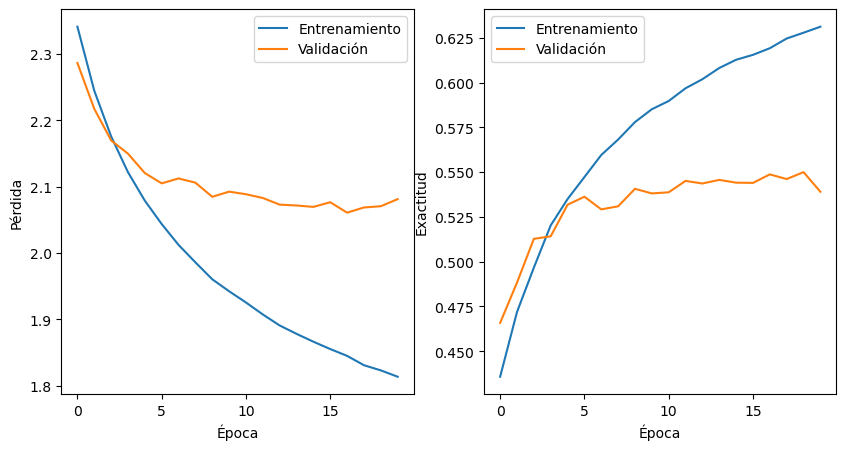

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

Se verifica el desempeño en el conjunto de prueba.

In [ ]:
total_pru = 0
acum_exact = 0.
for X_pru, y_pru, _, _ in dl_pru:
    X_pru = torch.flatten(X_pru, start_dim=2)
    X_pru = X_pru.to(DC)
    y_pru = y_pru.to(DC)
    y_hat_pru = mejor_red1(X_pru)
    total_pru += 1
    acum_exact += exactitud(y_hat_pru, y_pru)
exact_prom = acum_exact/total_pru
print("Exactitud en conjunto de prueba:\n", exact_prom)

Exactitud en conjunto de prueba:
 tensor(0.5437, device='cuda:0')


## Modelo de convolución 2d

Ahora se entrenará una red sin aplanar la onda.

In [ ]:
red2 = nn.Sequential(nn.Conv2d(x_sample.shape[1], 10, kernel_size=3, padding=1),
                     nn.ReLU(),
                     nn.Linear(x_sample.shape[-1], 20),
                     nn.BatchNorm2d(10),
                     nn.Flatten(),
                     nn.Dropout(p=0.25),
                     nn.Linear(25600, NUM_CLASSES))

Se prueba con el lote de ejemplo.

In [ ]:
y_hat_ds = red2.forward(x_sample)
print(y_hat_ds.shape)

torch.Size([32, 35])


Entrenamiento.

In [ ]:
red2.to(DC)

perdida = nn.CrossEntropyLoss(weight=None, reduction='mean', label_smoothing=0.1)
opt = Adam(red2.parameters(), lr=1e-4)

red2, mejor_red2, hist = entrena(red2, perdida, exactitud, opt, dl_ent, dl_val, DC, LOGDIR + 'red2.pt', n_epocas=N_EPOCAS, tbdir = LOGDIR, aplanar=False)


Época 0: Perdida(E) = 2.287, exactitud(E) = 0.509, Perdida(V) = 2.472, exactitud(V) = 0.473

Época 1: Perdida(E) = 2.183, exactitud(E) = 0.546, Perdida(V) = 2.429, exactitud(V) = 0.493

Época 2: Perdida(E) = 2.122, exactitud(E) = 0.569, Perdida(V) = 2.378, exactitud(V) = 0.499

Época 3: Perdida(E) = 2.088, exactitud(E) = 0.581, Perdida(V) = 2.455, exactitud(V) = 0.497

Época 4: Perdida(E) = 2.051, exactitud(E) = 0.598, Perdida(V) = 2.518, exactitud(V) = 0.502

Época 5: Perdida(E) = 2.025, exactitud(E) = 0.608, Perdida(V) = 2.397, exactitud(V) = 0.507

Época 6: Perdida(E) = 2.005, exactitud(E) = 0.616, Perdida(V) = 2.376, exactitud(V) = 0.502

Época 7: Perdida(E) = 1.981, exactitud(E) = 0.627, Perdida(V) = 2.364, exactitud(V) = 0.505

Época 8: Perdida(E) = 1.965, exactitud(E) = 0.633, Perdida(V) = 2.466, exactitud(V) = 0.502

Época 9: Perdida(E) = 1.951, exactitud(E) = 0.638, Perdida(V) = 2.604, exactitud(V) = 0.510

Época 10: Perdida(E) = 1.936, exactitud(E) = 0.645, Perdida(V) = 2.48

Se grafica la pérdida y la exactitud.

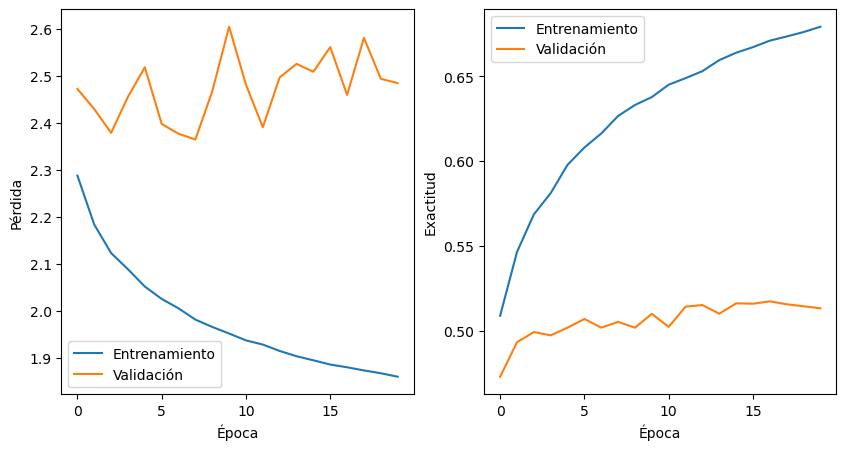

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

In [ ]:
total_pru = 0
acum_exact = 0.
for X_pru, y_pru, _, _ in dl_pru:
    X_pru = X_pru.to(DC)
    y_pru = y_pru.to(DC)
    y_hat_pru = mejor_red2(X_pru)
    total_pru += 1
    acum_exact += exactitud(y_hat_pru, y_pru)
exact_prom = acum_exact/total_pru
print("Exactitud en conjunto de prueba:\n", exact_prom)

Exactitud en conjunto de prueba:
 tensor(0.5169, device='cuda:0')


En ambos casos se observa una mejora en el conjunto de entrenamiento pero no en el de validación, lo cual puede indicar un sobreajuste. Sin embargo, el modelo aplanado mejoró un poco más que el no aplanado pues su exactitud en el conjunto de prueba fue de 54.37% y en el no aplanado fue de 51.69%.

También se puede observar cómo en el modelo 1-D, en el conjunto de validación se tiene una mejora al principio y luego se estanca en una meseta. Por otra parte, en el modelo no aplanado casi no se notan mejoras.